In [1]:
import warnings
warnings.filterwarnings("ignore")

import argparse
import shutil
import os
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from ae import AE, NAE
from modules import DeConvNet2, ConvNet2FC, FC_supermask_encode, FC_supermask_decode, FC_supermask_encode_nonstochastic, FC_supermask_decode_nonstochastic, FC_original_encode, FC_original_decode
from leaveout_dataset import MNISTLeaveOut
from tqdm import tqdm

from sklearn.metrics import roc_auc_score
from utils import roc_btw_arr
from torchvision.utils import make_grid, save_image
from torchvision.transforms import ToTensor

from tensorboardX import SummaryWriter



In [2]:
class args:
    device = 0
    run = 'testing'
    leave = 1
    pruning_ratio = 0.5
    
result_dir = f'snip_results/{args.run}/sparsitiy_{args.pruning_ratio}_leaveout_{args.leave}'
if not os.path.isdir(result_dir):
    os.makedirs(result_dir)
    print(f'creating {result_dir}')
shutil.copy('nae_experiment3_RE_supermask_freeze_RE_finetune.py', f'{result_dir}/nae_experiment3_RE_supermask_freeze_RE_finetune.py')
print(f'file copied: ', f'{result_dir}/nae_experiment3_RE_supermask_freeze_RE_finetune.py')

device = args.device
batch_size = 128
leave_out = args.leave

file copied:  snip_results/testing/sparsitiy_0.5_leaveout_1/nae_experiment3_RE_supermask_freeze_RE_finetune.py


In [3]:
def predict(m, dl, device, flatten=False):
    l_result = []
    for x, _ in dl:
        with torch.no_grad():
            if flatten:
                x = x.view(len(x), -1)
            pred = m.predict(x.cuda(device)).detach().cpu()
        l_result.append(pred)
    return torch.cat(l_result)


'''load dataset'''
ds = MNISTLeaveOut('dataset', [leave_out], split='training', transform=ToTensor(), download=True)
in_train_dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=10)
ds = MNISTLeaveOut('dataset', [leave_out], split='validation', transform=ToTensor(), download=True)
in_val_dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=10)
ds = MNISTLeaveOut('dataset', [leave_out], split='evaluation', transform=ToTensor(), download=True)
in_test_dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=10)

in_digits = list(set(list(range(10)))-set([leave_out]))
ds = MNISTLeaveOut('dataset', in_digits, split='validation', transform=ToTensor(), download=True)
out_val_dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=10)
ds = MNISTLeaveOut('dataset', in_digits, split='evaluation', transform=ToTensor(), download=True)
out_test_dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=10)


'''build model for RE loss weight training'''
encoder = FC_original_encode(device = device) #ConvNet2FC(1, z_dim, nh=8, nh_mlp=1024, out_activation='linear')
decoder = FC_original_decode(device = device) #DeConvNet2(z_dim, 1, nh=8, out_activation='sigmoid')
        
model = NAE(encoder, decoder)
model.cuda(device);

In [12]:
'''vs_whatever AUC'''
in_pred = predict(model, in_test_dl, device, True)
out_pred = predict(model, out_test_dl, device, True)
auc = roc_btw_arr(out_pred, in_pred)

In [13]:
auc

0.16522939540985562

In [14]:
encoder = FC_original_encode(device = device, previous_model = model, mask = mask) #ConvNet2FC(1, z_dim, nh=8, nh_mlp=1024, out_activation='linear')
decoder = FC_original_decode(device = device, previous_model = model, mask = mask) #ConvNet2FC(1, z_dim, nh=8, nh_mlp=1024, out_activation='linear')
        
check_model = NAE(encoder, decoder)
check_model.cuda(device);

512 784
256 512
128 256
64 128
128 64
256 128
512 256
784 512


In [16]:
in_pred = predict(check_model, in_test_dl, device, True)
out_pred = predict(check_model, out_test_dl, device, True)
auc = roc_btw_arr(out_pred, in_pred)
print(auc)

0.17037674764144498


In [4]:
from snip import SNIP

In [5]:
mask = SNIP(model,args.pruning_ratio, in_train_dl, device)

tensor(573440, device='cuda:0')


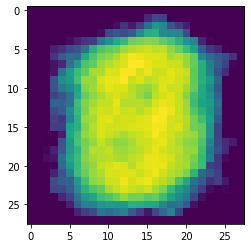

In [6]:
plt.imshow(mask[0].sum(axis=0).reshape(28,28).cpu().numpy())

In [7]:
'''build model for finetuning after training'''
encoder = FC_original_encode(device = device, previous_model = model, mask = mask) #ConvNet2FC(1, z_dim, nh=8, nh_mlp=1024, out_activation='linear')
decoder = FC_original_decode(device = device, previous_model = model, mask = mask) #ConvNet2FC(1, z_dim, nh=8, nh_mlp=1024, out_activation='linear')

new_model = NAE(encoder, decoder)
new_model.cuda(device);

512 784
256 512
128 256
64 128


In [8]:
'''AE Finetuning with frozen zero-weights'''
opt = Adam(new_model.parameters(), lr=0.0001)
writer = SummaryWriter(logdir=result_dir)


print('starting Finetuning AE with frozen weights...')
finetune_epoch = 50

'''Find-out the zero weights'''
locked_masks = dict()
for each_mask in mask:
    locked_masks[each_mask.shape]=each_mask==0

i = 0
for i_epoch in tqdm(range(finetune_epoch)):
    for x, _ in tqdm(in_train_dl):
        x = x.reshape(-1,784).cuda(device)
        d_result = new_model.train_step_ae_finetune(x, opt, locked_masks, clip_grad=None)

        writer.add_scalar('step2/loss', d_result['loss'], i + 1)
        writer.add_scalar('step2/z_norm', d_result['z_norm'], i + 1)
        writer.add_scalar('step2/recon_error', d_result['recon_error'], i + 1)
        writer.add_scalar('step2/encoder_l2', d_result['encoder_norm'], i + 1)
        writer.add_scalar('step2/decoder_l2', d_result['decoder_norm'], i + 1)

        if i % 50 == 0:
            '''val recon error'''
            val_err = predict(new_model, in_val_dl, device, flatten=True)
            
            in_pred = predict(new_model, in_test_dl, device, True)
            out_pred = predict(new_model, out_test_dl, device, True)
            auc = roc_btw_arr(out_pred, in_pred)
            writer.add_scalar('step2/AUROC', auc, i + 1)
            writer.add_scalar('step2/val_recon', val_err.mean().item(), i + 1)
            
        i += 1

torch.save(new_model.state_dict(), f'{result_dir}/ae_finetune.pkl')


'''vs_whatever AUC'''
in_pred = predict(new_model, in_test_dl, device, True)
out_pred = predict(new_model, out_test_dl, device, True)
auc = roc_btw_arr(out_pred, in_pred)

  0%|          | 0/375 [00:00<?, ?it/s]

starting Finetuning AE with frozen weights...



100%|██████████| 50/50 [18:54<00:00, 22.69s/it]


In [9]:
'''vs_whatever AUC'''
in_pred = predict(new_model, in_test_dl, device, True)
out_pred = predict(new_model, out_test_dl, device, True)
auc = roc_btw_arr(out_pred, in_pred)

In [11]:
auc

0.42327337870306186